Compare the TransformerLens implementation of a model to the Huggingface implementation. This script was originally use in https://github.com/TransformerLensOrg/TransformerLens/issues/570 to debug Mixtral.

## setup

In [1]:
%pip install transformers matplotlib

In [5]:
# Everything can be configured here
model_id = ""
text = "Hello my name is"
device="cpu"
# Set this to true to trigger hugging face login if needed
gated_model = False

In [2]:
# If you need a specific head, uncomment this and specify the head
# %pip install git+https://github.com/TransformerLensOrg/TransformerLens.git@head
# Otherwise, for running this on the latest release
%pip install transformer_lens

In [3]:
if gated_model:
    %pip install huggingface_hub
    from huggingface_hub import login
    login()

In [4]:
import einops
from torch.testing import assert_close
import torch
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

## TransformerLens model

In [6]:
tl_model = HookedTransformer.from_pretrained_no_processing(
    model_id,
    device=device,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model mistralai/Mixtral-8x7B-v0.1 into HookedTransformer


In [7]:
tl_model.generate(
    text,
    verbose=False,
    max_new_tokens=50,
)

'Hello my name is Kojo Akoto Boateng.  I was born in Accra at the Korle Bu Teaching Hospital.  I am the first born of Akoto Boateng.\n\nOn 23rd December, l was enrolled'

## Huggingface Model

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
hf_model = AutoModelForCausalLM.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
inputs = tokenizer(text, return_tensors="pt")
outputs = hf_model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Hello my name is Katie and I am a 20 year old student from the UK. I am currently studying a degree in English Literature and Creative Writing at the University of Winchester. I have always had a passion for writing and I am hoping to pursue


## Compare Model Weights

In [10]:
torch.all(
    einops.rearrange(tl_model.blocks[0].attn.W_Q, "n m h -> (n h) m") ==
    hf_model.model.layers[0].self_attn.q_proj.weight
)

tensor(True)

In [11]:
tl_model.blocks[0].attn.W_K.shape, hf_model.model.layers[0].self_attn.k_proj.weight.shape

(torch.Size([32, 4096, 128]), torch.Size([1024, 4096]))

In [12]:
torch.all(
    einops.reduce(
        tl_model.blocks[0].attn.W_K, "(n repeat) m h -> (n h) m",
        'max',
        n=tl_model.cfg.n_key_value_heads,
        repeat=4) ==
    hf_model.model.layers[0].self_attn.k_proj.weight
)

tensor(True)

In [13]:
torch.all(
    einops.reduce(
        tl_model.blocks[0].attn.W_V, "(n repeat) m h -> (n h) m",
        'max',
        n=tl_model.cfg.n_key_value_heads,
        repeat=4) ==
    hf_model.model.layers[0].self_attn.v_proj.weight
)

tensor(True)

In [14]:
torch.all(
    einops.rearrange(tl_model.blocks[0].attn.W_O, "n h m -> m (n h)") ==
    hf_model.model.layers[0].self_attn.o_proj.weight
)

tensor(True)

In [15]:
tl_model.blocks[0].attn.b_Q

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [16]:
torch.all(hf_model.model.layers[0].block_sparse_moe.gate.weight.T == tl_model.blocks[0].mlp.W_gate)

tensor(True)

In [17]:
hf_model.model.layers[0].block_sparse_moe.gate.weight.dtype, tl_model.blocks[0].mlp.W_gate.dtype

(torch.float32, torch.float32)

## Compare Layer Outputs

In [19]:
test_tensor = torch.randn((1, 1, 4096,))

In [20]:
hf_model.model.layers[0](test_tensor)

(tensor([[[ 0.3073,  0.6716, -1.5622,  ...,  0.1159,  0.7766, -0.2877]]],
        grad_fn=<AddBackward0>),)

In [21]:
tl_model.blocks[0](test_tensor)

tensor([[[ 0.3073,  0.6716, -1.5622,  ...,  0.1159,  0.7766, -0.2877]]],
       grad_fn=<AddBackward0>)

In [22]:
hf_model.model.layers[0](test_tensor)[0] == tl_model.blocks[0](test_tensor)

tensor([[[True, True, True,  ..., True, True, True]]])

In [23]:
hf_model.model.layers[0](test_tensor)[0][0, 0, -2].item(), tl_model.blocks[0](test_tensor)[0, 0, -2].item()

(0.7765660285949707, 0.7765660285949707)

In [24]:
torch.sum(hf_model.model.layers[0](test_tensor)[0] == tl_model.blocks[0](test_tensor))

tensor(3153)

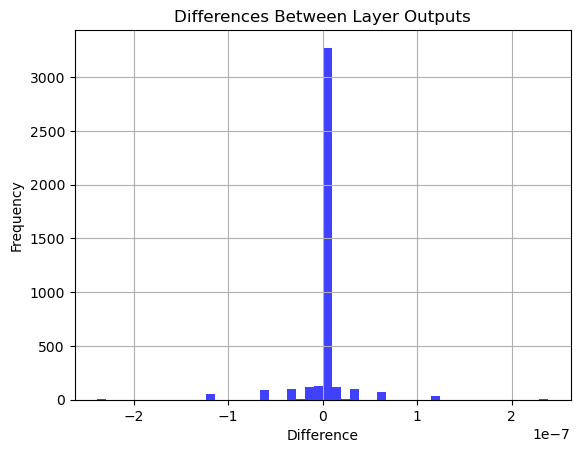

In [25]:
differences = hf_model.model.layers[0](test_tensor)[0] - tl_model.blocks[0](test_tensor)

# Flatten the differences to create a one-dimensional tensor
flattened_differences = differences.flatten().cpu().detach().numpy()

# Plot the histogram of the differences
plt.hist(flattened_differences, bins=50, alpha=0.75, color='blue')
plt.title('Differences Between Layer Outputs')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Compare MLP Outputs

In [26]:
torch.all(
    tl_model.blocks[0].mlp.experts[0].W_in ==
    hf_model.model.layers[0].block_sparse_moe.experts[0].w3.weight.T
)

tensor(True)

In [27]:
test_tensor = torch.randn((1, 1, 4096,))

In [28]:
torch.all(
    hf_model.model.layers[0].block_sparse_moe(test_tensor)[0] ==
    tl_model.blocks[0].mlp(test_tensor)
)

tensor(False)

In [29]:
hf_model.model.layers[0].block_sparse_moe(test_tensor)[0]

tensor([[[ 0.4624, -0.3203,  0.3846,  ...,  0.5780,  0.2270,  0.3475]]],
       grad_fn=<ReshapeAliasBackward0>)

In [30]:
tl_model.blocks[0].mlp(test_tensor)

tensor([[[ 0.4624, -0.3203,  0.3846,  ...,  0.5780,  0.2270,  0.3475]]],
       grad_fn=<IndexPutBackward0>)

In [31]:
tl_model.blocks[0].mlp(test_tensor).shape

torch.Size([1, 1, 4096])

In [32]:
hf_model.model.layers[0].block_sparse_moe(test_tensor)[0] == tl_model.blocks[0].mlp(test_tensor)

tensor([[[False, False, False,  ..., False, False, False]]])

In [33]:
torch.sum(hf_model.model.layers[0].block_sparse_moe(test_tensor)[0] == tl_model.blocks[0].mlp(test_tensor))

tensor(201)

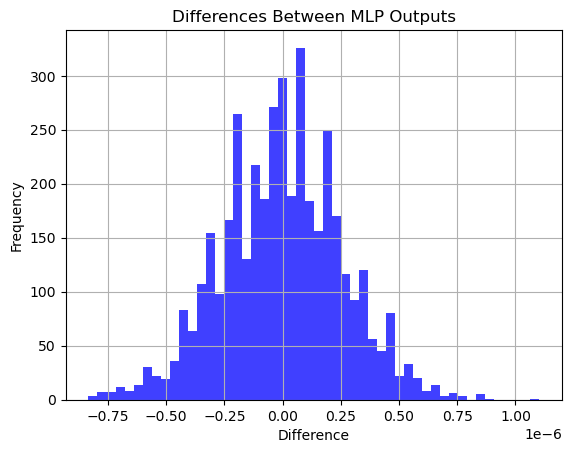

In [34]:
differences = hf_model.model.layers[0].block_sparse_moe(test_tensor)[0] - tl_model.blocks[0].mlp(test_tensor)

# Flatten the differences to create a one-dimensional tensor
flattened_differences = differences.flatten().cpu().detach().numpy()

# Plot the histogram of the differences
plt.hist(flattened_differences, bins=50, alpha=0.75, color='blue')
plt.title('Differences Between MLP Outputs')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [35]:
hf_model.model.layers[0].block_sparse_moe(test_tensor)[0][0, 0, 0].item()

0.46239426732063293

In [36]:
tl_model.blocks[0].mlp(test_tensor)[0, 0, 0].item()

0.4623942971229553

## Compare Attention Outputs

In [37]:
tl_model.blocks[0].attn.forward(test_tensor, test_tensor, test_tensor)

tensor([[[-0.3395,  0.2164, -0.0300,  ...,  0.1450,  0.0525, -0.1044]]],
       grad_fn=<AddBackward0>)

In [38]:
hf_model.model.layers[0].self_attn.forward(test_tensor)[0]

tensor([[[-0.3395,  0.2164, -0.0300,  ...,  0.1450,  0.0525, -0.1044]]],
       grad_fn=<UnsafeViewBackward0>)

In [39]:
(tl_model.blocks[0].attn.forward(test_tensor, test_tensor, test_tensor) == 
 hf_model.model.layers[0].self_attn.forward(test_tensor)[0])

tensor([[[False, False, False,  ..., False, False, False]]])

In [40]:
torch.sum(tl_model.blocks[0].attn.forward(test_tensor, test_tensor, test_tensor) == 
 hf_model.model.layers[0].self_attn.forward(test_tensor)[0])

tensor(236)

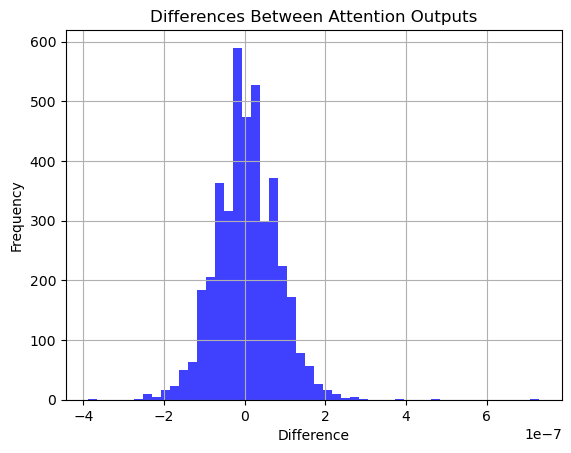

In [41]:
differences = tl_model.blocks[0].attn.forward(test_tensor, test_tensor, test_tensor) - hf_model.model.layers[0].self_attn.forward(test_tensor)[0]

# Flatten the differences to create a one-dimensional tensor
flattened_differences = differences.flatten().cpu().detach().numpy()

# Plot the histogram of the differences
plt.hist(flattened_differences, bins=50, alpha=0.75, color='blue')
plt.title('Differences Between Attention Outputs')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()